## Homework 6: Application Problem 2 - Optimal Exercise of American Options
### Black-Scholes formulas for European Call/Put Pricing
The Black-Shcoles formlas is given as:
$$
\begin{aligned} C ( S , t ) & = S _ { t } \Phi \left( d _ { 1 } \right) - e ^ { - r ( T - t ) } K \Phi \left( d _ { 2 } \right) \\ \text { where } d _ { 1 } & = \frac { \log \left( \frac { S _ { t } } { K } \right) + \left( r + \sigma ^ { 2 } / 2 \right) ( T - t ) } { \sigma \sqrt { T - t } } \\ \text { and } d _ { 2 } & = d _ { 1 } - \sigma \sqrt { T - t } \end{aligned}
$$

In [1]:
from typing import Tuple
import numpy as np
from scipy.stats import norm

class option:
    def __init__(self, s: float, k: float, r: float, T: int, t: int, mu: float, sigma: float) -> None:
        self.s = s
        self.k = k
        self.r = r
        self.T = T
        self.t = t
        self.mu = mu
        self.sigma = sigma
        self.d1, self.d2 = get_d1_d2()
        
    def get_d1_d2(self) -> Tuple[float, float]:
        d1 = (np.log(self.s / self.k) + (self.r + 0.5 * self.sigma ** 2) * (self.T-self.t)) / (self.sigma * np.sqrt(self.T-self.t))
        d2 = d1 - self.sigma * np.sqrt(self.T - self.t) 
        return d1, d2
        
    def call(self) -> float:
        return (self.s * norm.cdf(self.d1, 0, 1) - self.k * np.exp(-self.r * (self.T-self.t)) * norm.cdf(self.d2, 0, 1))
        
    def put(self) -> float:
        return (self.k * np.exp(-self.r * (self.T-self.t)) * norm.cdf(-self.d2, 0, 1) - self.s * norm.cdf(-self.d1, 0, 1))
        

### Standard binary tree/grid-based numerical algorithm for American Option  

Consider the following definition of binary tree:
$$
s _ { t + 1 } = \left\{ \begin{array} { l l } { ( 1 + r ) s _ { t } } & { \text { with probability } p } \\ { s _ { t } / ( 1 + r ) } & { \text { with probability } 1 - p } \end{array} \right.
$$

Value of an American Put: 
0.3757095164821912


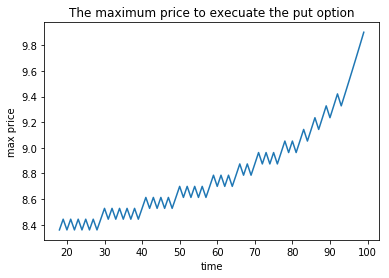

In [11]:
import matplotlib.pyplot as plt

def AmericanPut(T: int, p:float, r: float, X: float, s0: float) -> Tuple[float, np.array]:
    price_mat = np.zeros((T+1, T+1))
    for i in np.arange(T+1):
        price_mat[:(i+1), i] = (1 + r)**(-i + 2*np.arange(i+1))
    price_mat = price_mat*s0
    cashflow_mat = X - price_mat
    cashflow_mat = cashflow_mat*(cashflow_mat > 0)
    
    val_mat = cashflow_mat.copy()
    action_mat = np.zeros(val_mat.shape)
    for i in reversed(np.arange(T)):
        tmp1 = val_mat[:(i+2),i+1].copy()
        tmp0 = val_mat[:(i+1),i].copy()
        tmp3 = (1 - p)*tmp1[:-1] + p*tmp1[1:]
        tmp = np.concatenate((tmp3.reshape(len(tmp3),1), tmp0.reshape(len(tmp0),1)),1 )
        action_mat[:(i+1),i] = np.apply_along_axis(np.argmax, 1, tmp)
        val_mat[:(i+1),i] = np.apply_along_axis(max, 1, tmp)
    
    max_price_seq = np.zeros(T+1)
    max_price_loc = sum(action_mat) - 1
    for i in np.arange(T+1):
        if max_price_loc[i] == -1:
            max_price_seq[i] = -1
        else:
            max_price_seq[i] = price_mat[int(max_price_loc[i]),i]
            
    return val_mat[0,0], max_price_seq

put, max_price_seq = AmericanPut(100, 0.5, 0.01, 10, 10)
print('Value of an American Put: ')
print(put)
start = len(max_price_seq[:-1][max_price_seq[:-1]==-1])
end = 99
x_axis = np.linspace(start, end, end - start +1)
price = max_price_seq[max_price_seq>0]
plt.plot(x_axis, price)
plt.title('The maximum price to execuate the put option')
plt.ylabel('max price')
plt.xlabel('time')
plt.show()

In [17]:
from typing import Callable

def LongstaffSchwartz(SP: np.ndarray, Payoff: Callable[[Tuple[int, np.ndarray]], float], \
                      t: Callable[[int], float], r: Callable[[int], float], phi: Callable[[Tuple[int, np.ndarray]],list]):
    m = SP.shape[0] 
    n = SP.shape[1] - 1
    CF = np.array([Payoff((t(n), SP[i, :(n+1)])) for i in range(m)])
    for j in reversed(np.arange(n-1)+1):
        CF = CF*np.exp(-r(j)(t(j+1) - t(j)))
        X = np.array([phi((t(j), SP[i, :(j+1)])) for i in range(m) if Payoff((t(j), SP[i, :(j+1)]))>0])
        Y = np.array([CF[i] for i in range(m) if Payoff((t(j), SP[i, :(j+1)]))>0])
        w = np.linalg.pinv(X.T @ X) @ X.T @ Y
        for i in range(m):
            if Payoff((t(j), SP[i, :(j+1)])) > np.dot(w, np.array(phi((t(j), SP[i, :(j+1)])))):
                CF[i] = Payoff((t(j), SP[i, :(j+1)]))
    
    exercise = Payoff((t(0), SP[0, :(0+1)]))
    continue_ = np.exp(-r(0)*(t(1) - t(0)))*np.mean(CF)
    
    return (max(exercise,continue_))

